In [ ]:
# from src.flux import sampling
import random
import math
import os
import re
import time
from dataclasses import dataclass
from glob import iglob
from pathlib import Path
from typing import Dict, Tuple

import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from einops import rearrange
from fire import Fire
from PIL import Image
from torch.fft import fft2, fftshift, ifft2, ifftshift
from tqdm import tqdm
from transformers import pipeline
import yaml
import argparse



In [3]:

def _circle_mask(size=64, r=10, x_offset=0, y_offset=0):
    """Generate a circular mask."""
    
    x0 = y0 = size // 2
    x0 += x_offset
    y0 += y_offset
    y, x = np.ogrid[:size, :size]
    y = y[::-1]
    mask = ((x - x0)**2 + (y-y0)**2) <= r**2
    
    return mask

def _get_pattern(shape, w_pattern='ring', w_radius=10, w_seed=42):
    """Generate the watermark pattern."""
    gt_init = torch.randn(shape, generator=torch.Generator(device='cpu').manual_seed(w_seed))
    
    if w_pattern == 'ring':
        gt_patch = fftshift(fft2(gt_init), dim=(-1, -2))
        
        gt_patch_tmp = gt_patch.clone().detach()
        
        for i in range(w_radius, 0, -1):
            tmp_mask = _circle_mask(gt_init.shape[-1], r=i)
            tmp_mask = torch.tensor(tmp_mask, device=gt_init.device)
            
            
            for j in range(gt_patch.shape[1]):
                gt_patch[:, j, tmp_mask] = gt_patch_tmp[0, j, 0, i].item()
    

    return gt_patch



def create_watermarked_noise(
    height: int,
    width: int, 
    init_noise,
    w_channel: int = 0,
    w_radius: int = 10,
    device: str = "cuda",
    batch_size: int = 1,
    w_seed: int = 42,

) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    """Create watermarked noise for Flux."""
    
    shape = (batch_size, 16, 2 * math.ceil(height / 16), 2 * math.ceil(width / 16))
    
    # Create mask
    np_mask = _circle_mask(shape[-1], r=w_radius)
    torch_mask = torch.tensor(np_mask, device=device)
    w_mask = torch.zeros(shape, dtype=torch.bool, device=device)
    w_mask[:, w_channel] = torch_mask
    
    # Generate watermark pattern
    w_key = _get_pattern(shape, w_pattern='ring', w_radius=w_radius, w_seed=w_seed).to(device)
    
    # Generate and watermark the initial noise
    # init_noise = get_noise(batch_size, height, width, device=device, dtype=torch.float32, seed=rng.seed())
    
    # Convert to same dtype before FFT operations
    init_noise = init_noise.float()
    # w_key = w_key.float()
    
    noise_fft = fftshift(fft2(init_noise), dim=(-1, -2))
    
    noise_fft[w_mask] = w_key[w_mask].clone().to(noise_fft.dtype)
    watermarked_noise = ifft2(ifftshift(noise_fft, dim=(-1, -2))).real
    
    # Convert back to bfloat16 for Flux compatibility
    watermarked_noise = watermarked_noise.bfloat16()
    
    
    return watermarked_noise, w_key, w_mask

def create_watermarked_noise_ddim(
    height: int,
    width: int, 
    init_noise,
    w_channel: int = 0,
    w_radius: int = 10,
    device: str = "cuda",
    batch_size: int = 1,
    w_seed: int = 42,

) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    """Create watermarked noise for Flux."""
    
    shape = (batch_size, 4, 4 * math.ceil(height / 16), 4* math.ceil(width / 16))
    
    # Create mask
    np_mask = _circle_mask(shape[-1], r=w_radius)
    torch_mask = torch.tensor(np_mask, device=device)
    w_mask = torch.zeros(shape, dtype=torch.bool, device=device)
    w_mask[:, w_channel] = torch_mask
    
    # Generate watermark pattern
    w_key = _get_pattern(shape, w_pattern='ring', w_radius=w_radius, w_seed=w_seed).to(device)
    
    # Generate and watermark the initial noise
    # init_noise = get_noise(batch_size, height, width, device=device, dtype=torch.float32, seed=rng.seed())
    
    # Convert to same dtype before FFT operations
    init_noise = init_noise.float()
    # w_key = w_key.float()
    
    noise_fft = fftshift(fft2(init_noise), dim=(-1, -2))
    
    noise_fft[w_mask] = w_key[w_mask].clone().to(noise_fft.dtype)
    watermarked_noise = ifft2(ifftshift(noise_fft, dim=(-1, -2))).real
    
    # Convert back to bfloat16 for Flux compatibility
    watermarked_noise = watermarked_noise.bfloat16()
    
    
    return watermarked_noise, w_key, w_mask








def verify_watermark(
    reconstructed_noise: torch.Tensor,
    original_key: torch.Tensor,
    original_mask: torch.Tensor,
    threshold: float = 77.0
) -> bool:
    """
    Verify if watermark is present in reconstructed noise.
    """
    reconstructed_fft = fftshift(fft2(reconstructed_noise.float()), dim=(-1, -2))
    
    # Ensure the tensors have the correct dimensions before indexing
    if reconstructed_fft.dim() == 3:
        reconstructed_fft = reconstructed_fft.unsqueeze(0)
    if original_key.dim() == 3:
        original_key = original_key.unsqueeze(0)
    
    b = reconstructed_fft.shape[0]
    is_watermarked = []

    for i in range(b):
        dist = torch.abs(reconstructed_fft[i][original_mask[i]] - original_key[i][original_mask[i]]).mean()
        # if dist > threshold:
        #     print(f"WARNING: Watermark verification failed for batch {i}. Distance {dist:.2f} exceeds threshold {threshold:.2f}")
        #     is_watermarked.append(False)
        # else:
        #     print(f"INFO: Watermark verification succeeded for batch {i}. Distance {dist:.2f} is within threshold {threshold:.2f}")
        #     is_watermarked.append(True)
    
    return is_watermarked, dist

In [4]:
import h5py
import torch
import numpy as np

def load_noise_data(file_path):
    """
    Load initial and reconstructed noise from H5 file and convert to tensors.
    
    Args:
        file_path: Path to the H5 file
    
    Returns:
        tuple: (initial_noise_dict, reconstructed_noise_dict)
    """
    initial_noise_dict = {}
    reconstructed_noise_dict = {}
    
    with h5py.File(file_path, 'r') as f:
        # Get number of samples
        num_samples = len(f['watermark_verified'])
        
        # Load noise data for each sample
        for i in range(num_samples):
            # Get the noise data
            initial_noise = f['initial_noise'][str(f"sample_{i}")][:]
            reconstructed_noise = f['reconstructed_noise'][str(f"sample_{i}")][:]
            
            # Convert to PyTorch tensors
            initial_noise_tensor = torch.from_numpy(initial_noise)
            reconstructed_noise_tensor = torch.from_numpy(reconstructed_noise)
            
            # Store in dictionaries
            initial_noise_dict[i] = {
                'tensor': initial_noise_tensor,
                'shape': initial_noise_tensor.shape,
                'mean': initial_noise_tensor.mean().item(),
                'std': initial_noise_tensor.std().item()
            }
            
            reconstructed_noise_dict[i] = {  
                'tensor': reconstructed_noise_tensor,
                'shape': reconstructed_noise_tensor.shape,
                'mean': reconstructed_noise_tensor.mean().item(),
                'std': reconstructed_noise_tensor.std().item()
            }
            
            # Calculate error metrics
            mse = torch.mean((initial_noise_tensor - reconstructed_noise_tensor) ** 2).item()
            reconstructed_noise_dict[i]['mse_from_initial'] = mse
            
    return initial_noise_dict, reconstructed_noise_dict

# Load and compare noise data
# file_path = '/Users/ved14/Desktop/diffusion/small_tests/watermark_results_s28_g3.5_rg1.0_b32_si100_pi1_iw0.h5'
# initial_noise_dict, reconstructed_noise_dict = load_noise_data(file_path)
# all_initial_noise = torch.stack([initial_noise_dict[i]['tensor'] for i in  range(len(initial_noise_dict))])
# all_reconstructed_noise = torch.stack([reconstructed_noise_dict[i]['tensor'] for i in  range(len(reconstructed_noise_dict))])
# mean_initial_noise =all_initial_noise.mean(dim=0)
# mean_reconstructed_noise = all_reconstructed_noise.mean(dim =0)




# # Calculate distances for all reconstructed noise samples
# distances = []
# for i in range(len(all_reconstructed_noise)):
#     test_noise = all_reconstructed_noise[i].view(1, 16, 32, 32)
#     watermarked_noise, w_key, w_mask = create_watermarked_noise(height=256, width=256, init_noise=test_noise, device='cpu')
#     _, dist = verify_watermark(reconstructed_noise=test_noise, original_mask=w_mask, original_key=w_key)
#     distances.append(dist.item())

# # Plot density distribution
# plt.figure(figsize=(10, 6))
# plt.hist(distances, bins= 100, density=True, alpha=0.7)
# plt.xlabel('Distance')
# plt.ylabel('Density')
# plt.title('Distribution of Watermark Distances')
# plt.grid(True, alpha=0.3)
# plt.show()

# # Print some statistics

# print(f"Mean distance: {np.mean(distances):.2f}")
# print(f"Std deviation: {np.std(distances):.2f}")
# print(f"Min distance: {np.min(distances):.2f}")
# print(f"Max distance: {np.max(distances):.2f}")

## Flux Water vs Non-Water

In [4]:
import h5py
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import os

def to_numpy(tensor):
    return tensor.cpu().numpy() if torch.is_tensor(tensor) else tensor

def error_nmse(orig, recon):
    orig = to_numpy(orig).astype(np.float32)
    recon = to_numpy(recon).astype(np.float32)
    error = (np.linalg.norm((orig - recon)) / np.linalg.norm(orig))**2
    return error

def error_nmae(orig, recon):
    orig = to_numpy(orig).astype(np.float32)
    recon = to_numpy(recon).astype(np.float32)
    error = np.mean(np.abs(orig - recon)) / np.mean(np.abs(orig))
    return error

def load_noise_data_flux(file_path):
    initial_noise_dict = {}
    reconstructed_noise_dict = {}
    nmse_values = []
    nmae_values = []
    
    with h5py.File(file_path, 'r') as f:
        num_samples = len(f['watermark_verified'])
        
        for i in range(num_samples):
            initial_noise = f['initial_noise'][str(i)][:]
            reconstructed_noise = f['reconstructed_noise'][str(i)][:]
            
            initial_noise_tensor = torch.from_numpy(initial_noise)
            reconstructed_noise_tensor = torch.from_numpy(reconstructed_noise)
            
            nmse = error_nmse(initial_noise_tensor, reconstructed_noise_tensor)
            nmae = error_nmae(initial_noise_tensor, reconstructed_noise_tensor)
            
            nmse_values.append(nmse)
            nmae_values.append(nmae)
            
            initial_noise_dict[i] = {
                'tensor': initial_noise_tensor,
                'shape': initial_noise_tensor.shape,
                'mean': initial_noise_tensor.mean().item(),
                'std': initial_noise_tensor.std().item(),
                'nmse': nmse,
                'nmae': nmae
            }
            
            reconstructed_noise_dict[i] = {  
                'tensor': reconstructed_noise_tensor,
                'shape': reconstructed_noise_tensor.shape,
                'mean': reconstructed_noise_tensor.mean().item(),
                'std': reconstructed_noise_tensor.std().item(),
                'nmse': nmse,
                'nmae': nmae
            }
    
    return initial_noise_dict, reconstructed_noise_dict, np.mean(nmse_values), np.std(nmse_values), np.mean(nmae_values), np.std(nmae_values)

def calculate_distances_flux(file_path):
    initial_noise_dict, reconstructed_noise_dict, _, _, _, _ = load_noise_data_flux(file_path)
    all_reconstructed_noise = torch.stack([reconstructed_noise_dict[i]['tensor'] 
                                         for i in range(len(reconstructed_noise_dict))])
    
    distances = []
    for i in range(len(all_reconstructed_noise)):
        test_noise = all_reconstructed_noise[i].view(1, 16, 32, 32)
        watermarked_noise, w_key, w_mask = create_watermarked_noise(
            height=256, width=256, init_noise=test_noise, device='cpu'
        )
        _, dist = verify_watermark(
            reconstructed_noise=test_noise, 
            original_mask=w_mask, 
            original_key=w_key
        )
        distances.append(dist.item())
    
    return np.array(distances)

def kl_divergence(p, q):
    p_kde = stats.gaussian_kde(p)
    q_kde = stats.gaussian_kde(q)
    
    x_min = min(p.min(), q.min())
    x_max = max(p.max(), q.max())
    x = np.linspace(x_min, x_max, 1000)
    
    p_density = p_kde(x)
    q_density = q_kde(x)
    
    p_density = p_density / p_density.sum()
    q_density = q_density / q_density.sum()
    
    epsilon = 1e-10
    return np.sum(p_density * np.log((p_density + epsilon) / (q_density + epsilon)))

# def plot_watermark_comparison(watermarked_paths, non_watermarked_paths, names):
#     plt.style.use('seaborn-v0_8-whitegrid')
    
#     # Color scheme
#     watermarked_colors = ['#FF6B6B', '#FF9B9B']  # Red shades for watermarked
#     non_watermarked_colors = ['#4D96FF', '#6BCB77']  # Blue/Green shades for non-watermarked
    
#     fig, ax = plt.subplots(figsize=(16, 4), dpi=300)
    
#     all_distances = []
#     all_metrics = []
#     colors = []
    
#     # Process watermarked files
#     for i, file_path in enumerate(watermarked_paths):
#         distances = calculate_distances(file_path)
#         all_distances.append(distances)
#         colors.append(watermarked_colors[i])
        
#         _, _, nmse_mean, nmse_std, nmae_mean, nmae_std = load_noise_data(file_path)
#         all_metrics.append({
#             'nmae': f"NMAE: {nmae_mean:.3f}±{nmae_std:.3f}",
#             'nmse': f"NMSE: {nmse_mean:.3f}±{nmse_std:.3f}"
#         })
        
#     # Process non-watermarked files
#     for i, file_path in enumerate(non_watermarked_paths):
#         distances = calculate_distances(file_path)
#         all_distances.append(distances)
#         colors.append(non_watermarked_colors[i])
        
#         _, _, nmse_mean, nmse_std, nmae_mean, nmae_std = load_noise_data(file_path)
#         all_metrics.append({
#             'nmae': f"NMAE: {nmae_mean:.3f}±{nmae_std:.3f}",
#             'nmse': f"NMSE: {nmse_mean:.3f}±{nmse_std:.3f}"
#         })
    
#     # Calculate KL divergence between no-prompt cases (watermarked vs non-watermarked)
#     no_prompt_watermarked = all_distances[0]  # First watermarked file (no prompt)
#     no_prompt_non_watermarked = all_distances[2]  # First non-watermarked file (no prompt)
#     kl_forward = kl_divergence(no_prompt_watermarked, no_prompt_non_watermarked)
#     kl_backward = kl_divergence(no_prompt_non_watermarked, no_prompt_watermarked)
#     symmetric_kl = (kl_forward + kl_backward) / 2
    
#     # Plot distributions with wider x-axis
#     for i, (distances, name) in enumerate(zip(all_distances, names)):
#         density = stats.gaussian_kde(distances)
#         x_min = min([d.min() for d in all_distances])
#         x_max = max([d.max() for d in all_distances])
#         x_range = x_max - x_min
#         xs = np.linspace(x_min - 0.2*x_range, x_max + 0.2*x_range, 200)  # Extended x-axis
        
#         ax.fill_between(xs, density(xs), alpha=0.2, color=colors[i])
#         ax.plot(xs, density(xs), color=colors[i],
#                 label=name,
#                 linewidth=2.5 if "With Prompt" in name else 2.0,
#                 linestyle='-' if "With Prompt" in name else '--')
    
#     # Add metrics and statistics
#     text_y = 0.95
#     for i, (name, metrics) in enumerate(zip(names, all_metrics)):
#         dist_stats = f"Mean dist: $\\mathbf{{{np.mean(all_distances[i]):.3f} \\pm {np.std(all_distances[i]):.3f}}}$"
#         nmae_parts = metrics['nmae'].split(': ')[1].split('±')
#         nmse_parts = metrics['nmse'].split(': ')[1].split('±')
#         stats_text = (f"{name}\n"
#                      f"NMAE: $\\mathbf{{{nmae_parts[0]} \\pm {nmae_parts[1]}}}$\n"
#                      f"NMSE: $\\mathbf{{{nmse_parts[0]} \\pm {nmse_parts[1]}}}$\n"
#                      f"{dist_stats}")
#         ax.text(1.02, text_y - i*0.2,
#                 stats_text,
#                 transform=ax.transAxes,
#                 fontsize=10,
#                 color=colors[i],
#                 bbox=dict(facecolor='white',
#                          edgecolor=colors[i],
#                          alpha=0.8,
#                          pad=5))
    
#     # Add KL divergence information
#     ax.text(1.02, 0.15,
#             f"$\\text{{KL}}_{{\\text{{watermark-no watermark}}}}^{{\\text{{no prompt}}}} = \\mathbf{{{symmetric_kl:.3e}}}$",
#             transform=ax.transAxes,
#             fontsize=10,
#             bbox=dict(facecolor='white',
#                      edgecolor='gray',
#                      alpha=0.8,
#                      pad=5))
    
#     ax.set_xlabel('Watermark Distance', fontsize=12, fontweight='bold')
#     ax.set_ylabel('Density', fontsize=12, fontweight='bold')
#     ax.set_title("Watermarked vs Non-Watermarked Comparison:\n$p(\\Vert\\mathcal{F}(\\text{recon}_{\\text{noise}}) - \\text{key}\\Vert_1)$",
#                 fontsize=14, fontweight='bold', pad=20)
    
#     ax.grid(True, linestyle='--', alpha=0.7)
#     ax.set_axisbelow(True)
#     ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
#     ax.legend(loc='upper right', bbox_to_anchor=(0.98, 0.98), fontsize =14)
    
#     plt.tight_layout()
#     plt.show()

# Example usage (replace with your actual file paths):
# watermarked_paths = [
#     "path_to_watermarked_no_prompt.h5",
#     "path_to_watermarked_with_prompt.h5"
# ]

# non_watermarked_paths = [
#     "path_to_non_watermarked_no_prompt.h5",
#     "path_to_non_watermarked_with_prompt.h5"
# ]

# names = [
#     "Watermarked (No Prompt)",
#     "Watermarked (With Prompt)",
#     "Non-Watermarked (No Prompt)",
#     "Non-Watermarked (With Prompt)"
# ]


# Example usage with your file paths
# watermarked_paths = [
#     "/Users/ved14/Desktop/diffusion/watermark_experiments/watermark_results_20250207-050102_watermark_True_promptguidance_False_.h5",
#     "/Users/ved14/Desktop/diffusion/watermark_experiments/watermark_results_20250207-014734_watermark_True_promptguidance_True_.h5"
# ]

# non_watermarked_paths = [
#     "/Users/ved14/Desktop/diffusion/watermark_experiments/watermark_results_no_attack_no_prompt_without_watermark/watermark_results_20250207-155634_watermark_False_promptguidance_False_.h5",
#     "/Users/ved14/Desktop/diffusion/watermark_experiments/watermark_results_no_attack_with_prompt_without_watermark/watermark_results_20250207-124308_watermark_False_promptguidance_True_.h5"
# ]

# names = [
#     "Watermarked (No Prompt)",
#     "Watermarked (With Prompt)",
#     "Non-Watermarked (No Prompt)",
#     "Non-Watermarked (With Prompt)"
# ]

# plot_watermark_comparison(watermarked_paths, non_watermarked_paths, names)


### DDIM water vs Non water

In [5]:
import h5py
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import os

def to_numpy(tensor):
    return tensor.cpu().numpy() if torch.is_tensor(tensor) else tensor

def error_nmse(orig, recon):
    orig = to_numpy(orig).astype(np.float32)
    recon = to_numpy(recon).astype(np.float32)
    error = (np.linalg.norm((orig - recon)) / np.linalg.norm(orig))**2
    return error

def error_nmae(orig, recon):
    orig = to_numpy(orig).astype(np.float32)
    recon = to_numpy(recon).astype(np.float32)
    error = np.mean(np.abs(orig - recon)) / np.mean(np.abs(orig))
    return error

def load_noise_data_ddim(file_path):
    initial_noise_dict = {}
    reconstructed_noise_dict = {}
    nmse_values = []
    nmae_values = []
    
    with h5py.File(file_path, 'r') as f:
        keys = list(f.keys())
        num_samples = len(f['reconstructed_noise'])  # For DDIM format
        
        for i in range(num_samples):
            initial_noise = f['initial_noise'][f"sample_{i}"][:]  # DDIM format
            reconstructed_noise = f['reconstructed_noise'][f"sample_{i}"][:] # DDIM format
            
            initial_noise_tensor = torch.from_numpy(initial_noise)
            reconstructed_noise_tensor = torch.from_numpy(reconstructed_noise)
            
            nmse = error_nmse(initial_noise_tensor, reconstructed_noise_tensor)
            nmae = error_nmae(initial_noise_tensor, reconstructed_noise_tensor)
            
            nmse_values.append(nmse)
            nmae_values.append(nmae)
            
            initial_noise_dict[i] = {
                'tensor': initial_noise_tensor,
                'shape': initial_noise_tensor.shape,
                'mean': initial_noise_tensor.mean().item(),
                'std': initial_noise_tensor.std().item(),
                'nmse': nmse,
                'nmae': nmae
            }
            
            reconstructed_noise_dict[i] = {  
                'tensor': reconstructed_noise_tensor,
                'shape': reconstructed_noise_tensor.shape,
                'mean': reconstructed_noise_tensor.mean().item(),
                'std': reconstructed_noise_tensor.std().item(),
                'nmse': nmse,
                'nmae': nmae
            }
    
    return initial_noise_dict, reconstructed_noise_dict, np.mean(nmse_values), np.std(nmse_values), np.mean(nmae_values), np.std(nmae_values)

def calculate_distances_ddim(file_path):
    initial_noise_dict, reconstructed_noise_dict, _, _, _, _ = load_noise_data_ddim(file_path)
    all_reconstructed_noise = torch.stack([reconstructed_noise_dict[i]['tensor'] 
                                         for i in range(len(reconstructed_noise_dict))])
    
    distances = []
    for i in range(len(all_reconstructed_noise)):
        test_noise = all_reconstructed_noise[i].view(1, 4, 64, 64)
        watermarked_noise, w_key, w_mask = create_watermarked_noise_ddim(
            height=256, width=256, init_noise=test_noise, device='cpu'
        )
        _, dist = verify_watermark(
            reconstructed_noise=test_noise, 
            original_mask=w_mask, 
            original_key=w_key
        )
        distances.append(dist.item())
    
    return np.array(distances)

def kl_divergence(p, q):
    p_kde = stats.gaussian_kde(p)
    q_kde = stats.gaussian_kde(q)
    
    x_min = min(p.min(), q.min())
    x_max = max(p.max(), q.max())
    x = np.linspace(x_min, x_max, 1000)
    
    p_density = p_kde(x)
    q_density = q_kde(x)
    
    p_density = p_density / p_density.sum()
    q_density = q_density / q_density.sum()
    
    epsilon = 1e-10
    return np.sum(p_density * np.log((p_density + epsilon) / (q_density + epsilon)))

def plot_ddim_watermark_comparison(base_path):
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.rcParams['font.size'] = 14  # Increase base font size
    plt.rcParams['axes.labelsize'] = 16
    plt.rcParams['axes.titlesize'] = 18
    plt.rcParams['legend.fontsize'] = 14
    
    # Define file paths based on the pattern
    file_paths = {
        'w1_p0': os.path.join(base_path, 'results_naive_0_1023_pi0_w1.h5'),
        'w1_p1': os.path.join(base_path, 'results_naive_0_1023_pi1_w1.h5'),
        'w0_p0': os.path.join(base_path, 'results_naive_0_1023_pi0_w0.h5'),
        'w0_p1': os.path.join(base_path, 'results_naive_0_1023_pi1_w0.h5')
    }
    
    names = [
        "Watermarked (No Prompt)",
        "Watermarked (With Prompt)",
        "Non-Watermarked (No Prompt)",
        "Non-Watermarked (With Prompt)"
    ]
    
    # Enhanced color scheme with better contrast
    watermarked_colors = ['#FF4B4B', '#FF7B7B']  # Stronger red shades
    non_watermarked_colors = ['#2D76FF', '#4BAB57']  # Stronger blue/green shades
    colors = watermarked_colors + non_watermarked_colors
    
    # Increase DPI and figure size for sharper output
    fig, ax = plt.subplots(figsize=(18, 10), dpi=400)
    
    all_distances = []
    all_metrics = []
    
    # Process files in order
    for file_key, file_path in file_paths.items():
        distances = calculate_distances_ddim(file_path)
        all_distances.append(distances)
        
        _, _, nmse_mean, nmse_std, nmae_mean, nmae_std = load_noise_data_ddim(file_path)
        all_metrics.append({
            'nmae': f"NMAE: {nmae_mean:.3f}±{nmae_std:.3f}",
            'nmse': f"NMSE: {nmse_mean:.3f}±{nmse_std:.3f}"
        })
    
    # Calculate KL divergence
    no_prompt_watermarked = all_distances[0]
    no_prompt_non_watermarked = all_distances[2]
    kl_forward = kl_divergence(no_prompt_watermarked, no_prompt_non_watermarked)
    kl_backward = kl_divergence(no_prompt_non_watermarked, no_prompt_watermarked)
    symmetric_kl = (kl_forward + kl_backward) / 2
    
    # Plot distributions with enhanced line weights
    for i, (distances, name) in enumerate(zip(all_distances, names)):
        density = stats.gaussian_kde(distances)
        x_min = min([d.min() for d in all_distances])
        x_max = max([d.max() for d in all_distances])
        x_range = x_max - x_min
        xs = np.linspace(x_min - 0.2*x_range, x_max + 0.2*x_range, 300)  # Increased points for smoother curves
        
        ax.fill_between(xs, density(xs), alpha=0.25, color=colors[i])  # Slightly increased alpha
        ax.plot(xs, density(xs), color=colors[i],
                label=name,
                linewidth=3.0 if "With Prompt" in name else 2.5,  # Increased line width
                linestyle='-' if "With Prompt" in name else '--')
    
    # Add metrics and statistics with larger font
    text_y = 0.95
    for i, (name, metrics) in enumerate(zip(names, all_metrics)):
        dist_stats = f"Mean dist: $\\mathbf{{{np.mean(all_distances[i]):.3f} \\pm {np.std(all_distances[i]):.3f}}}$"
        nmae_parts = metrics['nmae'].split(': ')[1].split('±')
        nmse_parts = metrics['nmse'].split(': ')[1].split('±')
        stats_text = (f"{name}\n"
                     f"NMAE: $\\mathbf{{{nmae_parts[0]} \\pm {nmae_parts[1]}}}$\n"
                     f"NMSE: $\\mathbf{{{nmse_parts[0]} \\pm {nmse_parts[1]}}}$\n"
                     f"{dist_stats}")
        ax.text(1.02, text_y - i*0.2,
                stats_text,
                transform=ax.transAxes,
                fontsize=12,  # Increased font size
                color=colors[i],
                bbox=dict(facecolor='white',
                         edgecolor=colors[i],
                         alpha=0.9,  # Increased alpha
                         pad=6))
    
    # Add KL divergence information with larger font
    ax.text(1.02, 0.15,
            f"$\\text{{KL}}_{{\\text{{watermark-no watermark}}}}^{{\\text{{no prompt}}}} = \\mathbf{{{symmetric_kl:.3e}}}$",
            transform=ax.transAxes,
            fontsize=12,
            bbox=dict(facecolor='white',
                     edgecolor='gray',
                     alpha=0.9,
                     pad=6))
    
    ax.set_xlabel('Watermark Distance', fontsize=16, fontweight='bold')
    ax.set_ylabel('Density', fontsize=16, fontweight='bold')
    ax.set_title("DDIM: Watermarked vs Non-Watermarked Comparison:\n$p(\\Vert\\mathcal{F}(\\text{recon}_{\\text{noise}}) - \\text{key}\\Vert_1)$",
                fontsize=18, fontweight='bold', pad=20)
    
    # Enhanced grid and tick parameters
    ax.grid(True, linestyle='--', alpha=0.7, linewidth=1.2)
    ax.set_axisbelow(True)
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    
    # Enhanced legend
    legend = ax.legend(loc='upper right', bbox_to_anchor=(0.98, 0.98), 
                      fontsize=14, framealpha=0.95, edgecolor='gray')
    legend.get_frame().set_linewidth(1.2)
    
    plt.tight_layout()
    plt.show()

    # Optionally save the figure in high resolution
    # plt.savefig('watermark_comparison.png', dpi=400, bbox_inches='tight')

# Example usage
# base_path = "/Users/ved14/Desktop/diffusion/watermark_experiments/ddim_results"
# plot_ddim_watermark_comparison(base_path)

## FLUX vs DDIM comparison Watermarked vs Non-Watermarked

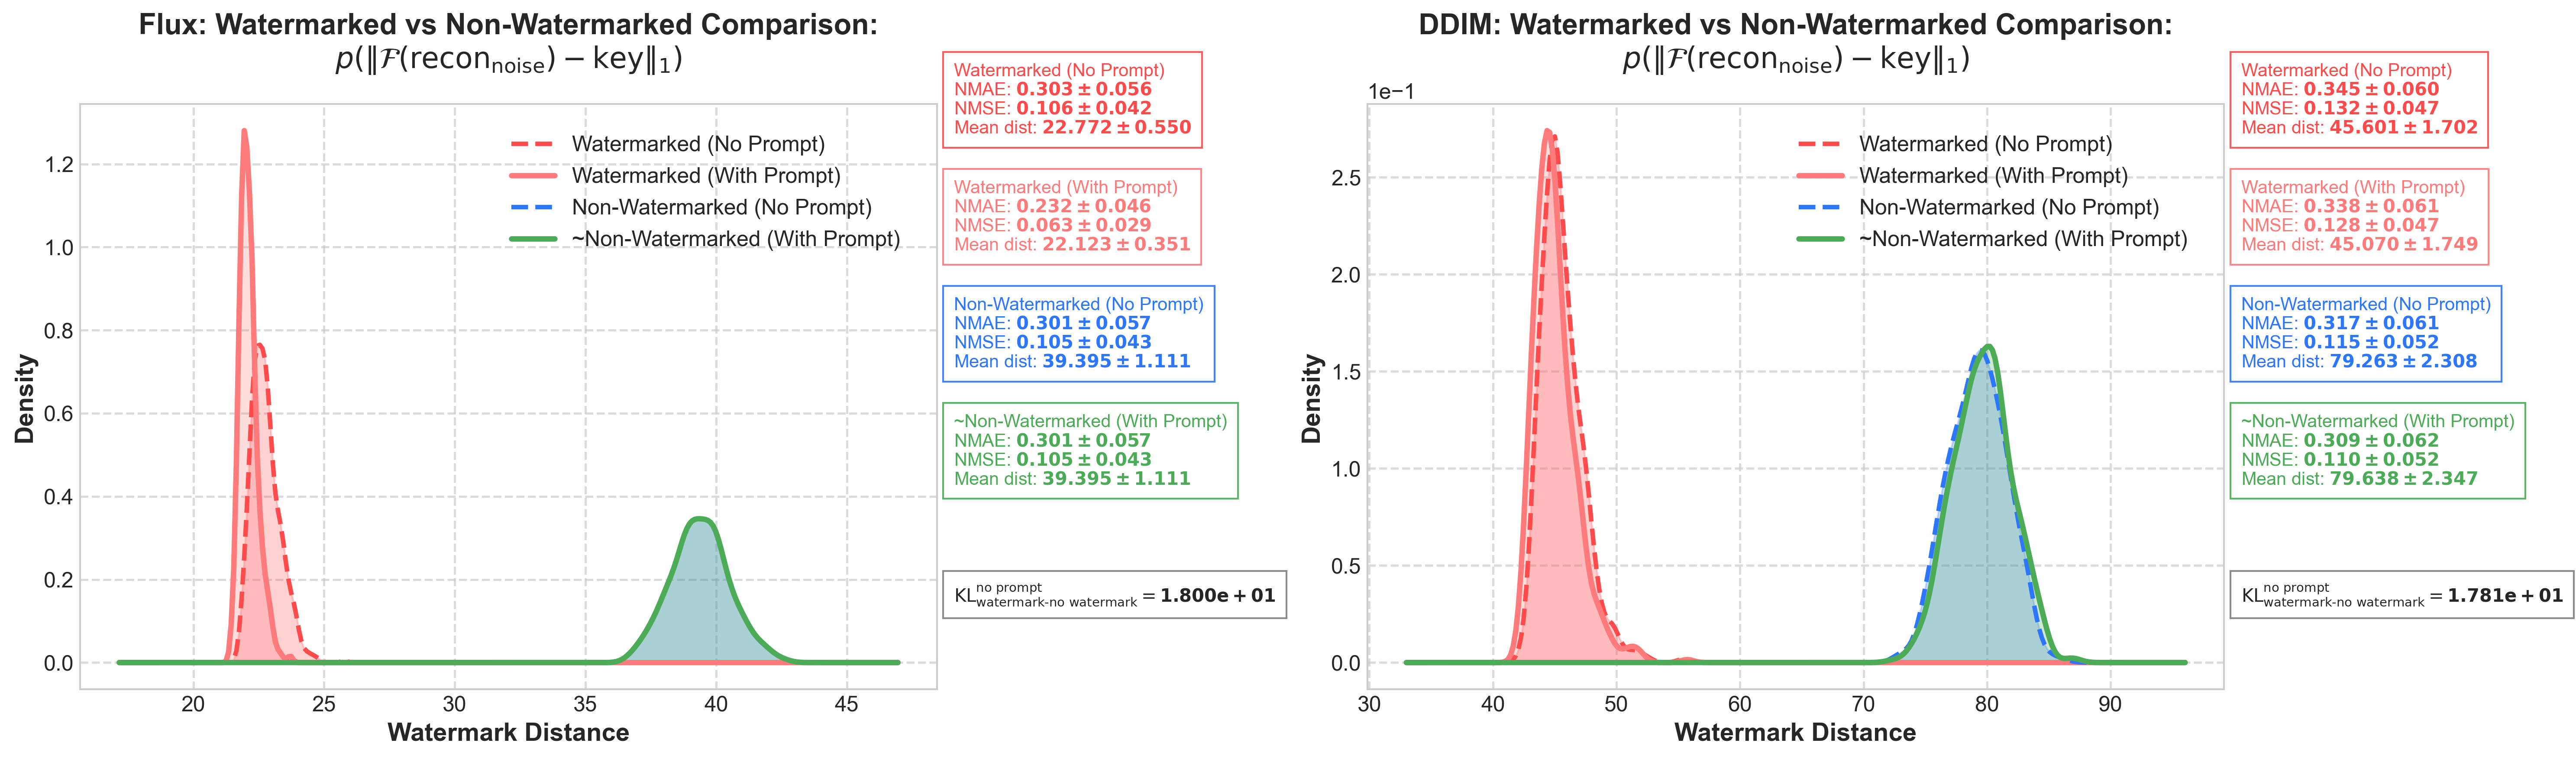

In [6]:
import h5py
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import os

def plot_combined_comparison(flux_paths, ddim_base_path):
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.rcParams['font.size'] = 12
    plt.rcParams['axes.labelsize'] = 14
    plt.rcParams['axes.titlesize'] = 16
    plt.rcParams['legend.fontsize'] = 12
    
    # Create figure with two subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6), dpi=300)
    
    # Color schemes
    watermarked_colors = ['#FF4B4B', '#FF7B7B']  # Strong red shades
    non_watermarked_colors = ['#2D76FF', '#4BAB57']  # Strong blue/green shades
    colors = watermarked_colors + non_watermarked_colors
    
    # Process Flux data (left subplot)
    watermarked_paths = flux_paths['watermarked']
    non_watermarked_paths = flux_paths['non_watermarked']
    names = [
        "Watermarked (No Prompt)",
        "Watermarked (With Prompt)",
        "Non-Watermarked (No Prompt)",
        "~Non-Watermarked (With Prompt)"
    ]
    
    all_distances_flux = []
    all_metrics_flux = []
    
    # Process watermarked files
    for file_path in watermarked_paths:
        distances = calculate_distances_flux(file_path)
        all_distances_flux.append(distances)
        _, _, nmse_mean, nmse_std, nmae_mean, nmae_std = load_noise_data_flux(file_path)
        all_metrics_flux.append({
            'nmae': f"NMAE: {nmae_mean:.3f}±{nmae_std:.3f}",
            'nmse': f"NMSE: {nmse_mean:.3f}±{nmse_std:.3f}"
        })
    
    # Process non-watermarked files
    for file_path in non_watermarked_paths:
        distances = calculate_distances_flux(file_path)
        all_distances_flux.append(distances)
        _, _, nmse_mean, nmse_std, nmae_mean, nmae_std = load_noise_data_flux(file_path)
        all_metrics_flux.append({
            'nmae': f"NMAE: {nmae_mean:.3f}±{nmae_std:.3f}",
            'nmse': f"NMSE: {nmse_mean:.3f}±{nmse_std:.3f}"
        })
    
    # Plot Flux distributions
    plot_distributions(ax1, all_distances_flux, names, colors, all_metrics_flux, "Flux")
    
    # Process DDIM data (right subplot)
    ddim_file_paths = {
        'w1_p0': os.path.join(ddim_base_path, 'results_naive_i_0_512_pi0_w1.h5'),
        'w1_p1': os.path.join(ddim_base_path, 'results_naive_i_0_512_pi1_w1.h5'),
        'w0_p0': os.path.join(ddim_base_path, 'results_naive_i_0_512_pi0_w0.h5'),
        'w0_p1': os.path.join(ddim_base_path, 'results_naive_i_0_512_pi1_w0.h5')
    }
    
    all_distances_ddim = []
    all_metrics_ddim = []
    
    for file_path in ddim_file_paths.values():
        distances = calculate_distances_ddim(file_path)
        all_distances_ddim.append(distances)
        _, _, nmse_mean, nmse_std, nmae_mean, nmae_std = load_noise_data_ddim(file_path)
        all_metrics_ddim.append({
            'nmae': f"NMAE: {nmae_mean:.3f}±{nmae_std:.3f}",
            'nmse': f"NMSE: {nmse_mean:.3f}±{nmse_std:.3f}"
        })
    
    # Plot DDIM distributions
    plot_distributions(ax2, all_distances_ddim, names, colors, all_metrics_ddim, "DDIM")
    
    plt.tight_layout()
    plt.show()

def plot_distributions(ax, all_distances, names, colors, all_metrics, model_name):
    # Calculate KL divergence
    no_prompt_watermarked = all_distances[0]
    no_prompt_non_watermarked = all_distances[2]
    kl_forward = kl_divergence(no_prompt_watermarked, no_prompt_non_watermarked)
    kl_backward = kl_divergence(no_prompt_non_watermarked, no_prompt_watermarked)
    symmetric_kl = (kl_forward + kl_backward) / 2
    
    # Plot distributions
    for i, (distances, name) in enumerate(zip(all_distances, names)):
        density = stats.gaussian_kde(distances)
        x_min = min([d.min() for d in all_distances])
        x_max = max([d.max() for d in all_distances])
        x_range = x_max - x_min
        xs = np.linspace(x_min - 0.2*x_range, x_max + 0.2*x_range, 300)
        
        ax.fill_between(xs, density(xs), alpha=0.25, color=colors[i])
        ax.plot(xs, density(xs), color=colors[i],
                label=name,
                linewidth=3.0 if "With Prompt" in name else 2.5,
                linestyle='-' if "With Prompt" in name else '--')
    
    # Add metrics and statistics
    text_y = 0.95
    for i, (name, metrics) in enumerate(zip(names, all_metrics)):
        dist_stats = f"Mean dist: $\\mathbf{{{np.mean(all_distances[i]):.3f} \\pm {np.std(all_distances[i]):.3f}}}$"
        nmae_parts = metrics['nmae'].split(': ')[1].split('±')
        nmse_parts = metrics['nmse'].split(': ')[1].split('±')
        stats_text = (f"{name}\n"
                     f"NMAE: $\\mathbf{{{nmae_parts[0]} \\pm {nmae_parts[1]}}}$\n"
                     f"NMSE: $\\mathbf{{{nmse_parts[0]} \\pm {nmse_parts[1]}}}$\n"
                     f"{dist_stats}")
        ax.text(1.02, text_y - i*0.2,
                stats_text,
                transform=ax.transAxes,
                fontsize=10,
                color=colors[i],
                bbox=dict(facecolor='white',
                         edgecolor=colors[i],
                         alpha=0.9,
                         pad=6))
    
    # Add KL divergence information
    ax.text(1.02, 0.15,
            f"$\\text{{KL}}_{{\\text{{watermark-no watermark}}}}^{{\\text{{no prompt}}}} = \\mathbf{{{symmetric_kl:.3e}}}$",
            transform=ax.transAxes,
            fontsize=10,
            bbox=dict(facecolor='white',
                     edgecolor='gray',
                     alpha=0.9,
                     pad=6))
    
    ax.set_xlabel('Watermark Distance', fontsize=14, fontweight='bold')
    ax.set_ylabel('Density', fontsize=14, fontweight='bold')
    ax.set_title(f"{model_name}: Watermarked vs Non-Watermarked Comparison:\n$p(\\Vert\\mathcal{{F}}(\\text{{recon}}_{{\\text{{noise}}}}) - \\text{{key}}\\Vert_1)$",
                fontsize=16, fontweight='bold', pad=20)
    
    ax.grid(True, linestyle='--', alpha=0.7, linewidth=1.2)
    ax.set_axisbelow(True)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    
    legend = ax.legend(loc='upper right', bbox_to_anchor=(0.98, 0.98),
                      fontsize=12, framealpha=0.95, edgecolor='gray')
    legend.get_frame().set_linewidth(1.2)

# Example usage
flux_paths = {
    'watermarked': [
         "/Users/ved14/Desktop/diffusion/watermark_experiments/flux_results/revised_results/watermark_results_no_attack_no_prompt_with_watermark_keep_im/watermark_results_20250210-050417_watermark_True_promptguidance_False_.h5",
        "/Users/ved14/Desktop/diffusion/watermark_experiments/flux_results/revised_results/watermark_results_no_attack_with_prompt_with_watermark_keep_im/watermark_results_20250210-001703_watermark_True_promptguidance_True_.h5",
       ],
    'non_watermarked': [
        "/Users/ved14/Desktop/diffusion/watermark_experiments/flux_results/keep_im/watermark_results_no_attack_no_prompt_without_watermark_keep_im/watermark_results_20250209-175501_watermark_False_promptguidance_False_.h5",
        "/Users/ved14/Desktop/diffusion/watermark_experiments/flux_results/keep_im/watermark_results_no_attack_no_prompt_without_watermark_keep_im/watermark_results_20250209-175501_watermark_False_promptguidance_False_.h5"
    ]
}

ddim_base_path = "/Users/ved14/Desktop/diffusion/watermark_experiments/ddim_results/naive_i"

plot_combined_comparison(flux_paths, ddim_base_path)

## Attacked vs non attacked scenarios Flux


Generating combined plot for both scenarios...


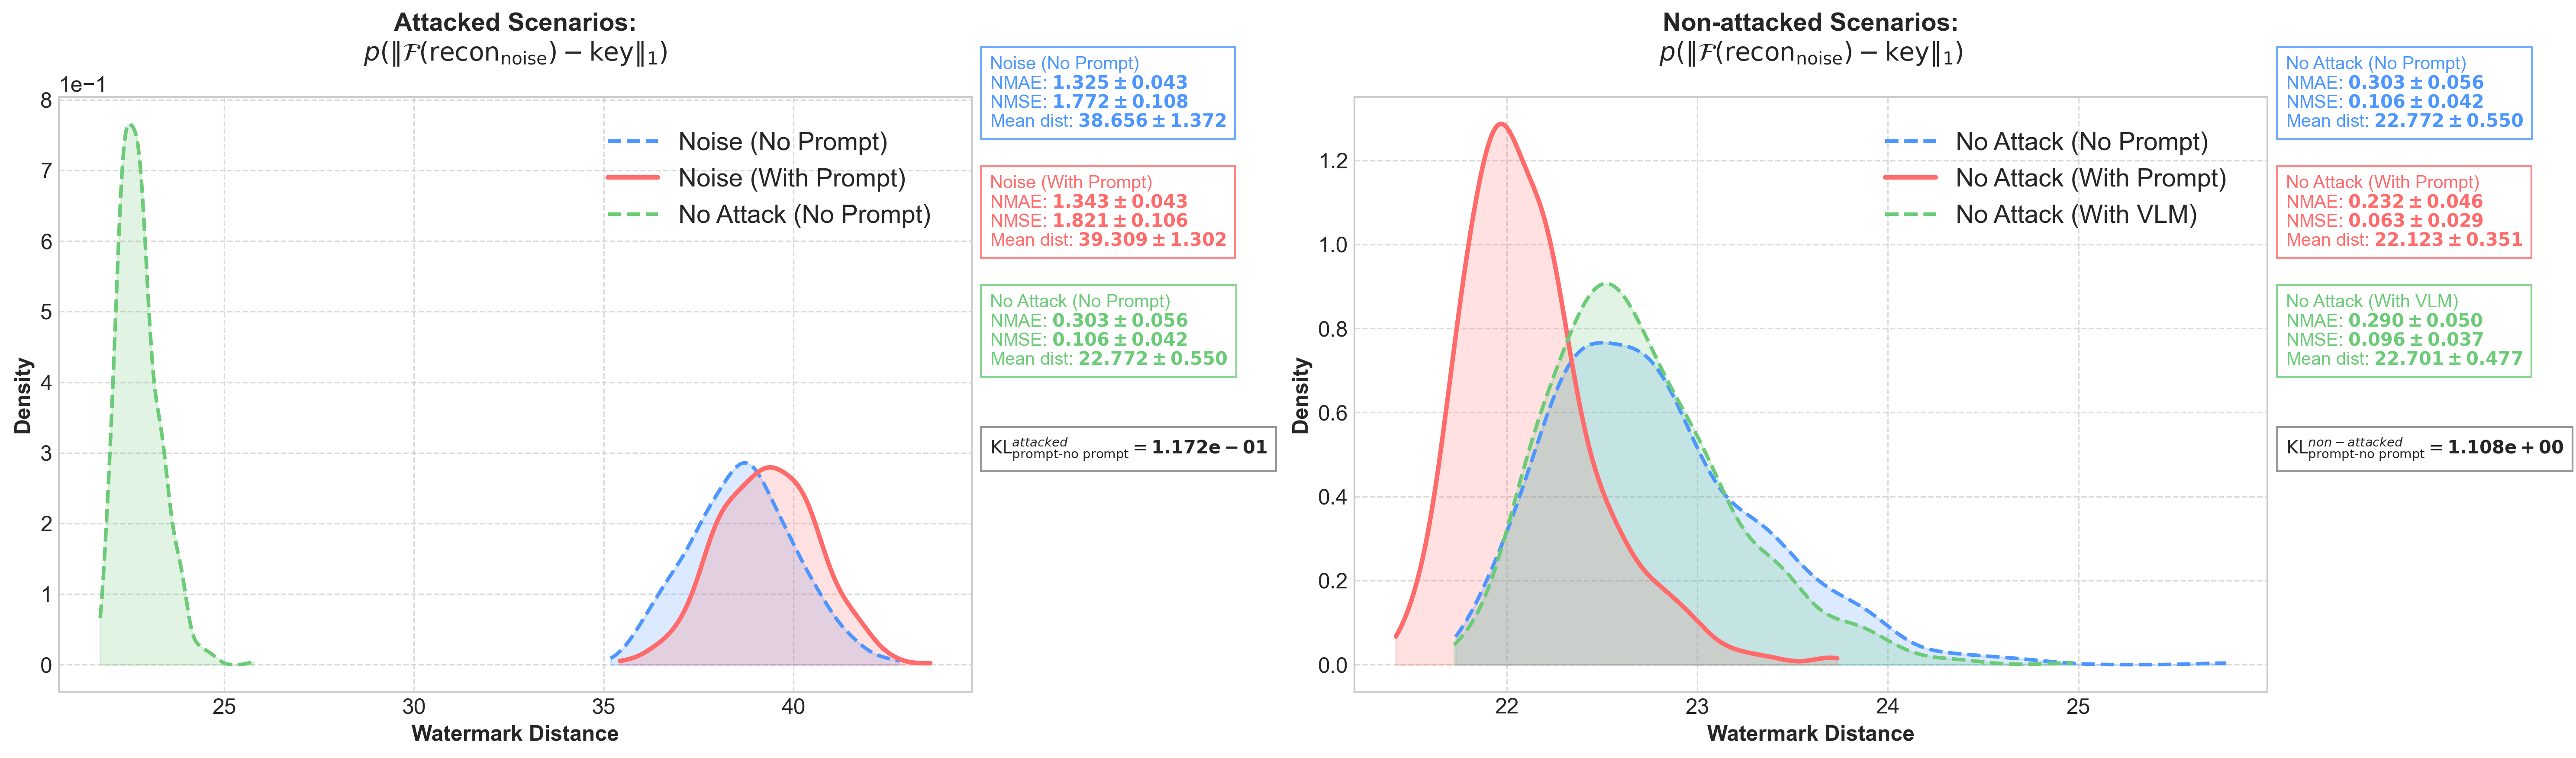

In [7]:
import h5py
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import os

def to_numpy(tensor):
    return tensor.cpu().numpy() if torch.is_tensor(tensor) else tensor

def error_nmse(orig, recon):
    orig = to_numpy(orig).astype(np.float32)
    recon = to_numpy(recon).astype(np.float32)
    error = (np.linalg.norm((orig - recon)) / np.linalg.norm(orig))**2
    return error

def error_nmae(orig, recon):
    orig = to_numpy(orig).astype(np.float32)
    recon = to_numpy(recon).astype(np.float32)
    error = np.mean(np.abs(orig - recon)) / np.mean(np.abs(orig))
    return error

def load_noise_data(file_path):
    initial_noise_dict = {}
    reconstructed_noise_dict = {}
    nmse_values = []
    nmae_values = []
    
    with h5py.File(file_path, 'r') as f:
        num_samples = len(f['watermark_verified'])
        
        for i in range(num_samples):
            initial_noise = f['initial_noise'][str(i)][:]
            reconstructed_noise = f['reconstructed_noise'][str(i)][:]
            
            initial_noise_tensor = torch.from_numpy(initial_noise)
            reconstructed_noise_tensor = torch.from_numpy(reconstructed_noise)
            
            nmse = error_nmse(initial_noise_tensor, reconstructed_noise_tensor)
            nmae = error_nmae(initial_noise_tensor, reconstructed_noise_tensor)
            
            nmse_values.append(nmse)
            nmae_values.append(nmae)
            
            initial_noise_dict[i] = {
                'tensor': initial_noise_tensor,
                'shape': initial_noise_tensor.shape,
                'mean': initial_noise_tensor.mean().item(),
                'std': initial_noise_tensor.std().item(),
                'nmse': nmse,
                'nmae': nmae
            }
            
            reconstructed_noise_dict[i] = {  
                'tensor': reconstructed_noise_tensor,
                'shape': reconstructed_noise_tensor.shape,
                'mean': reconstructed_noise_tensor.mean().item(),
                'std': reconstructed_noise_tensor.std().item(),
                'nmse': nmse,
                'nmae': nmae
            }
    
    return initial_noise_dict, reconstructed_noise_dict, np.mean(nmse_values), np.std(nmse_values), np.mean(nmae_values), np.std(nmae_values)

def calculate_distances(file_path):
    initial_noise_dict, reconstructed_noise_dict, _, _, _, _ = load_noise_data(file_path)
    all_reconstructed_noise = torch.stack([reconstructed_noise_dict[i]['tensor'] 
                                         for i in range(len(reconstructed_noise_dict))])
    
    distances = []
    for i in range(len(all_reconstructed_noise)):
        test_noise = all_reconstructed_noise[i].view(1, 16, 32, 32)
        watermarked_noise, w_key, w_mask = create_watermarked_noise(
            height=256, width=256, init_noise=test_noise, device='cpu'
        )
        _, dist = verify_watermark(
            reconstructed_noise=test_noise, 
            original_mask=w_mask, 
            original_key=w_key
        )
        distances.append(dist.item())
    
    return np.array(distances)

def kl_divergence(p, q):
    p_kde = stats.gaussian_kde(p)
    q_kde = stats.gaussian_kde(q)
    
    x_min = min(p.min(), q.min())
    x_max = max(p.max(), q.max())
    x = np.linspace(x_min, x_max, 1000)
    
    p_density = p_kde(x)
    q_density = q_kde(x)
    
    p_density = p_density / p_density.sum()
    q_density = q_density / q_density.sum()
    
    epsilon = 1e-10
    return np.sum(p_density * np.log((p_density + epsilon) / (q_density + epsilon)))

def plot_combined_analysis(attacked_paths, attacked_names, non_attacked_paths, non_attacked_names):
    plt.style.use('seaborn-v0_8-whitegrid')
    
    # Color scheme
    prompt_colors = ['#FF6B6B', '#FF9B9B']  # Red shades
    no_prompt_colors = ['#4D96FF', '#6BCB77', '#9B6BFF']  # Blue/Green/Purple shades
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6), dpi=300)
    
    # Function to process and plot data for each subplot
    def process_and_plot(ax, file_paths, names, scenario_type):
        colors = []
        for name in names:
            if "(With Prompt)" in name:
                colors.append(prompt_colors[len([c for c in colors if "(With Prompt)" in names[colors.index(c)]]) % len(prompt_colors)])
            else:
                colors.append(no_prompt_colors[len([c for c in colors if "(With Prompt)" not in names[colors.index(c)]]) % len(no_prompt_colors)])
        
        all_distances = []
        all_metrics = []
        
        for file_path in file_paths:
            distances = calculate_distances(file_path)
            all_distances.append(distances)
            
            _, _, nmse_mean, nmse_std, nmae_mean, nmae_std = load_noise_data(file_path)
            all_metrics.append({
                'nmae': f"NMAE: {nmae_mean:.3f}±{nmae_std:.3f}",
                'nmse': f"NMSE: {nmse_mean:.3f}±{nmse_std:.3f}"
            })
        
        # Calculate KL divergence if we have both prompt and no-prompt cases
        if len(all_distances) >= 2:
            no_prompt_dist = all_distances[0]
            with_prompt_dist = all_distances[1]
            kl_forward = kl_divergence(no_prompt_dist, with_prompt_dist)
            kl_backward = kl_divergence(with_prompt_dist, no_prompt_dist)
            symmetric_kl = (kl_forward + kl_backward) / 2
        
        # Plot distributions
        for i, (distances, name) in enumerate(zip(all_distances, names)):
            density = stats.gaussian_kde(distances)
            xs = np.linspace(min(distances), max(distances), 200)
            ax.fill_between(xs, density(xs), alpha=0.2, color=colors[i])
            ax.plot(xs, density(xs), color=colors[i],
                    label=name,
                    linewidth=2.5 if "(With Prompt)" in name else 2.0,
                    linestyle='-' if "(With Prompt)" in name else '--')
        
        # Add metrics and statistics as text box
        text_y = 0.95
        for i, (name, metrics) in enumerate(zip(names, all_metrics)):
            dist_stats = f"Mean dist: $\\mathbf{{{np.mean(all_distances[i]):.3f} \\pm {np.std(all_distances[i]):.3f}}}$"
            nmae_parts = metrics['nmae'].split(': ')[1].split('±')
            nmse_parts = metrics['nmse'].split(': ')[1].split('±')
            stats_text = (f"{name}\n"
                         f"NMAE: $\\mathbf{{{nmae_parts[0]} \\pm {nmae_parts[1]}}}$\n"
                         f"NMSE: $\\mathbf{{{nmse_parts[0]} \\pm {nmse_parts[1]}}}$\n"
                         f"{dist_stats}")
            ax.text(1.02, text_y - i*0.2,
                    stats_text,
                    transform=ax.transAxes,
                    fontsize=10,
                    color=colors[i],
                    bbox=dict(facecolor='white',
                             edgecolor=colors[i],
                             alpha=0.8,
                             pad=5))
        
        if len(all_distances) >= 2:
            ax.text(1.02, 0.4,
                    f"$\\text{{KL}}_{{\\text{{prompt-no prompt}}}}^{{{scenario_type}}} = \\mathbf{{{symmetric_kl:.3e}}}$",
                    transform=ax.transAxes,
                    fontsize=10,
                    bbox=dict(facecolor='white',
                             edgecolor='gray',
                             alpha=0.8,
                             pad=5))
        
        ax.set_xlabel('Watermark Distance', fontsize=12, fontweight='bold')
        ax.set_ylabel('Density', fontsize=12, fontweight='bold')
        ax.set_title(f"{scenario_type.capitalize()} Scenarios:\n$p(\\Vert\\mathcal{{F}}(\\text{{recon}}_\\text{{noise}}) - \\text{{key}}\\Vert_1)$",
                    fontsize=14, fontweight='bold', pad=20)
        
        ax.grid(True, linestyle='--', alpha=0.7)
        ax.set_axisbelow(True)
        ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
        ax.legend(loc='upper right', bbox_to_anchor=(0.98, 0.98), fontsize =14)
    
    # Process and plot both scenarios
    process_and_plot(ax1, attacked_paths, attacked_names, "attacked")
    process_and_plot(ax2, non_attacked_paths, non_attacked_names, "non-attacked")
    
    plt.tight_layout()
    plt.show()

# File paths for attacked scenarios
attacked_file_paths = [
    "//Users/ved14/Desktop/diffusion/watermark_experiments/flux_results/noise_attack/watermark_results_noise_no_prompt_after_enlightment/watermark_results_20250210-154808_watermark_True_promptguidance_False_.h5",
    "/Users/ved14/Desktop/diffusion/watermark_experiments/flux_results/noise_attack/watermark_results_noise_with_prompt_after_enlightment/watermark_results_20250210-140600_watermark_True_promptguidance_True_.h5",
    # "/Users/ved14/Desktop/diffusion/watermark_experiments/flux_results/revised_results/BLUR/watermark_results_blur_no_prompt_keep_im/watermark_results_20250210-175442_watermark_True_promptguidance_False_.h5",
    # "/Users/ved14/Desktop/diffusion/watermark_experiments/flux_results/revised_results/BLUR/watermark_results_blur_with_prompt_keep_im/watermark_results_20250210-200629_watermark_True_promptguidance_True_.h5",
    "/Users/ved14/Desktop/diffusion/watermark_experiments/flux_results/revised_results/watermark_results_no_attack_no_prompt_with_watermark_keep_im/watermark_results_20250210-050417_watermark_True_promptguidance_False_.h5",

]

attacked_names = [
    "Noise (No Prompt)",
    "Noise (With Prompt)",
    "No Attack (No Prompt)",
    # "Noise+Jitter+Blur (With VLM)",
]

# File paths for non-attacked scenarios
non_attacked_file_paths = [
    "/Users/ved14/Desktop/diffusion/watermark_experiments/flux_results/revised_results/watermark_results_no_attack_no_prompt_with_watermark_keep_im/watermark_results_20250210-050417_watermark_True_promptguidance_False_.h5",
    "/Users/ved14/Desktop/diffusion/watermark_experiments/flux_results/revised_results/watermark_results_no_attack_with_prompt_with_watermark_keep_im/watermark_results_20250210-001703_watermark_True_promptguidance_True_.h5",
    "/Users/ved14/Desktop/diffusion/watermark_experiments/flux_results/revised_results/watermark_results_no_attack_no_prompt_with_watermark_vlm_keep_im/watermark_results_20250210-111525_watermark_True_promptguidance_False_.h5"
]

non_attacked_names = [
    "No Attack (No Prompt)",
    "No Attack (With Prompt)",
    "No Attack (With VLM)"
]

# Generate combined plot
print("Generating combined plot for both scenarios...")
plot_combined_analysis(attacked_file_paths, attacked_names, non_attacked_file_paths, non_attacked_names)


Detailed Metrics Across All Scenarios:
{'Scenario': ['Attacked', 'Attacked', 'Attacked', 'Non-Attacked', 'Non-Attacked', 'Non-Attacked', 'Flux Model', 'Flux Model', 'Flux Model', 'Flux Model', 'DDIM Model', 'DDIM Model', 'DDIM Model', 'DDIM Model'], 'Configuration': ['Noise (No Prompt)', 'Noise (With Prompt)', 'No Attack (No Prompt)', 'No Attack (No Prompt)', 'No Attack (With Prompt)', 'No Attack (With VLM)', 'Watermarked (No Prompt)', 'Watermarked (With Prompt)', 'Non-Watermarked (No Prompt)', 'Non-Watermarked (With Prompt)', 'Watermarked (No Prompt)', 'Watermarked (With Prompt)', 'Non-Watermarked (No Prompt)', 'Non-Watermarked (With Prompt)'], 'NMAE': [1.3247094, 1.3429801, 0.3025963, 0.3025963, 0.23185976, 0.289551, 0.3025963, 0.23185976, 0.3013481, 0.3013481, 0.3453353, 0.33841312, 0.31746763, 0.309314], 'NMAE_std': [0.043323882, 0.04252258, 0.055822488, 0.055822488, 0.046161033, 0.04982302, 0.055822488, 0.046161033, 0.05659579, 0.05659579, 0.06039499, 0.060851604, 0.06127551, 0.0

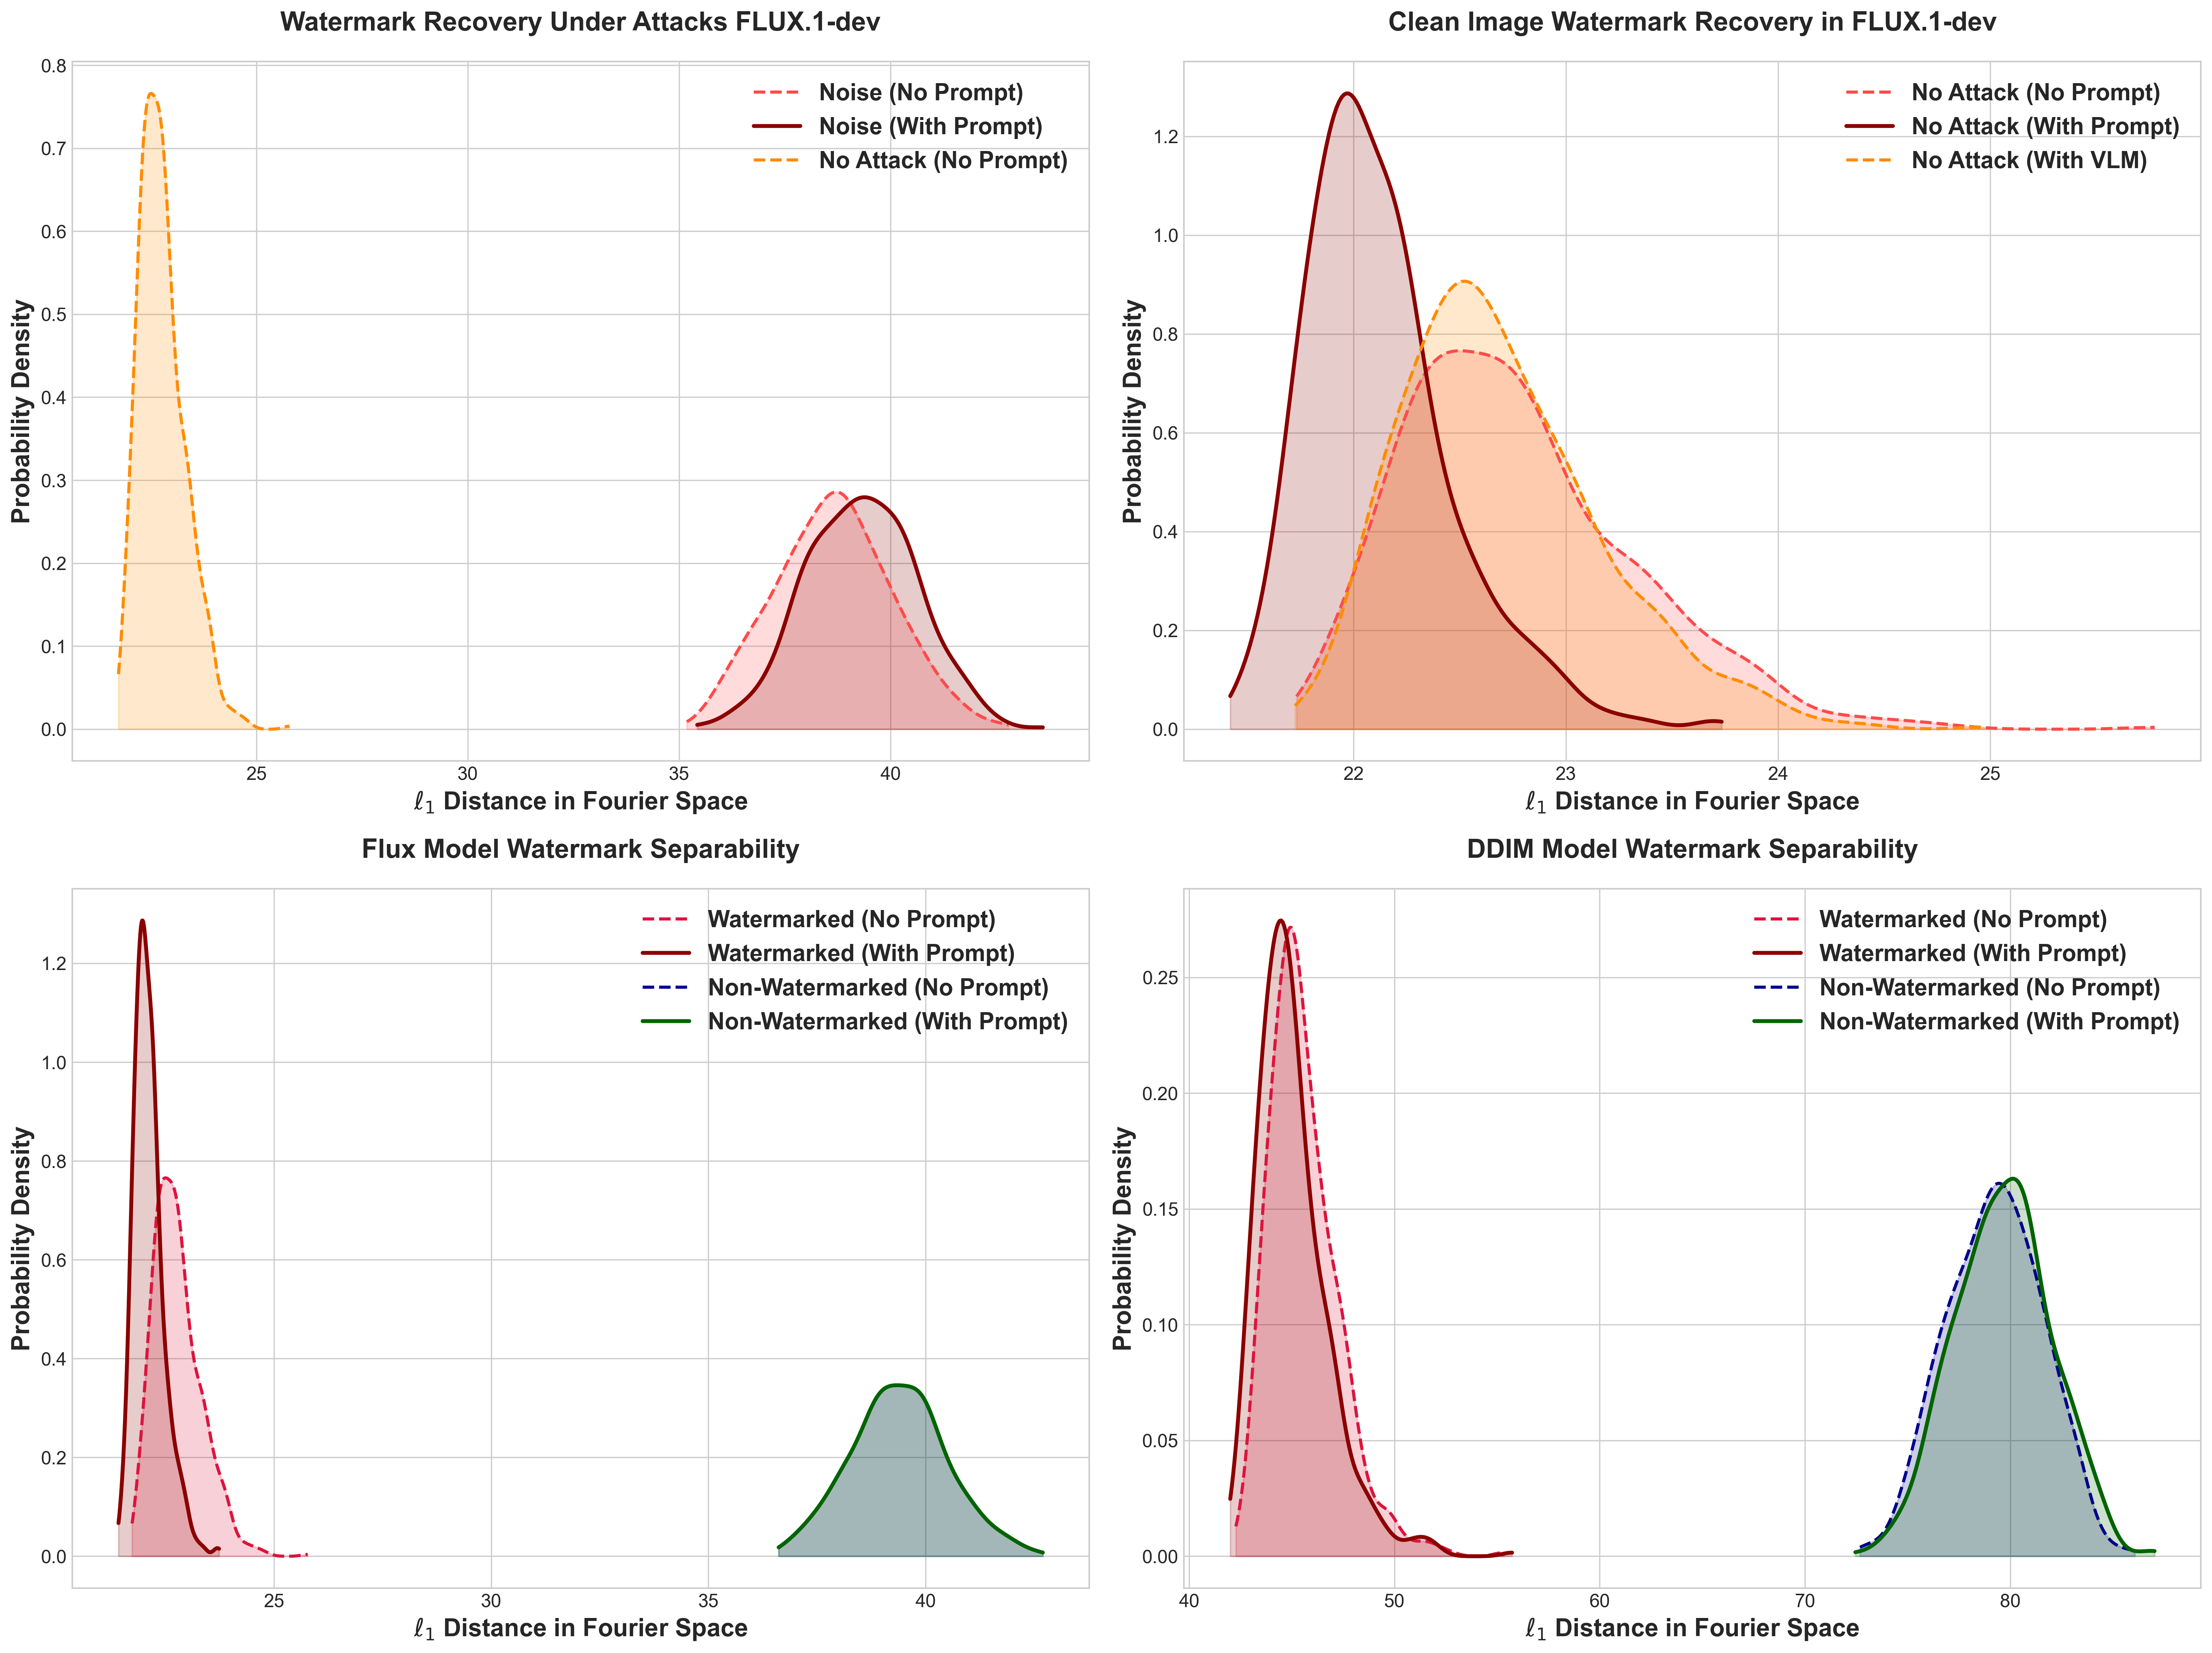

In [8]:
import h5py
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import os
import pandas as pd

def plot_four_panel_analysis(attacked_paths, attacked_names, non_attacked_paths, non_attacked_names, 
                           flux_paths, ddim_base_path):
    plt.style.use('seaborn-v0_8-whitegrid')
    
    # Create figure with 2x2 subplot grid
    fig, axes = plt.subplots(2, 2, figsize=(20, 15), dpi=300)
    
    # Font settings
    plt.rcParams['font.size'] = 14
    plt.rcParams['font.weight'] = 'bold'
    plt.rcParams['axes.labelweight'] = 'bold'
    plt.rcParams['axes.titleweight'] = 'bold'
    
    # Color schemes
    prompt_colors = ['#FF4B4B', '#8B0000', '#FF8C00']  # Deep red, dark red, dark orange
    no_prompt_colors = ['#0047AB', '#006400', '#4B0082']  # Cobalt blue, dark green, indigo
    watermarked_colors = ['#DC143C', '#8B0000']  # Crimson, dark red
    non_watermarked_colors = ['#00008B', '#006400']  # Dark blue, dark green
    
    # Dictionary to store all metrics
    all_metrics_dict = {
        'Scenario': [],
        'Configuration': [],
        'NMAE': [],
        'NMAE_std': [],
        'NMSE': [],
        'NMSE_std': [],
        'Mean_Distance': [],
        'Distance_Std': [],
        'KLD': []
    }
    
    # Plot 1: Attacked Scenarios (Top Left)
    def plot_attacked_scenarios(ax):
        all_distances = []
        
        for i, (file_path, name) in enumerate(zip(attacked_paths, attacked_names)):
            distances = calculate_distances_flux(file_path)
            all_distances.append(distances)
            
            _, _, nmse_mean, nmse_std, nmae_mean, nmae_std = load_noise_data_flux(file_path)
            
            # Store metrics
            all_metrics_dict['Scenario'].append('Attacked')
            all_metrics_dict['Configuration'].append(name)
            all_metrics_dict['NMAE'].append(nmae_mean)
            all_metrics_dict['NMAE_std'].append(nmae_std)
            all_metrics_dict['NMSE'].append(nmse_mean)
            all_metrics_dict['NMSE_std'].append(nmse_std)
            all_metrics_dict['Mean_Distance'].append(np.mean(distances))
            all_metrics_dict['Distance_Std'].append(np.std(distances))
            
            density = stats.gaussian_kde(distances)
            xs = np.linspace(min(distances), max(distances), 200)
            ax.fill_between(xs, density(xs), alpha=0.2, color=prompt_colors[i])
            ax.plot(xs, density(xs), color=prompt_colors[i],
                   label=name,
                   linewidth=2.5 if "With Prompt" in name else 2.0,
                   linestyle='-' if "With Prompt" in name else '--')
        
        # Calculate KLD
        if len(all_distances) >= 2:
            kl_div = (kl_divergence(all_distances[0], all_distances[1]) + 
                     kl_divergence(all_distances[1], all_distances[0])) / 2
            all_metrics_dict['KLD'].extend([kl_div, kl_div])
        
        ax.set_title('Watermark Recovery Under Attacks FLUX.1-dev', fontsize=17, fontweight='bold', pad=20)
        ax.set_xlabel('$\\ell_1$ Distance in Fourier Space', fontsize=16, fontweight='bold')
        ax.set_ylabel('Probability Density', fontsize=16, fontweight='bold')
        ax.legend(loc='upper right', framealpha=0.9, edgecolor='gray', fontsize=15)
        ax.tick_params(labelsize=12)
    
    # Plot 2: Non-Attacked Scenarios (Top Right)
    def plot_non_attacked_scenarios(ax):
        all_distances = []
        
        for i, (file_path, name) in enumerate(zip(non_attacked_paths, non_attacked_names)):
            distances = calculate_distances_flux(file_path)
            all_distances.append(distances)
            
            _, _, nmse_mean, nmse_std, nmae_mean, nmae_std = load_noise_data_flux(file_path)
            
            # Store metrics
            all_metrics_dict['Scenario'].append('Non-Attacked')
            all_metrics_dict['Configuration'].append(name)
            all_metrics_dict['NMAE'].append(nmae_mean)
            all_metrics_dict['NMAE_std'].append(nmae_std)
            all_metrics_dict['NMSE'].append(nmse_mean)
            all_metrics_dict['NMSE_std'].append(nmse_std)
            all_metrics_dict['Mean_Distance'].append(np.mean(distances))
            all_metrics_dict['Distance_Std'].append(np.std(distances))
            
            colors = prompt_colors + [no_prompt_colors[0]]
            density = stats.gaussian_kde(distances)
            xs = np.linspace(min(distances), max(distances), 200)
            ax.fill_between(xs, density(xs), alpha=0.2, color=colors[i])
            ax.plot(xs, density(xs), color=colors[i],
                   label=name,
                   linewidth=2.5 if "With Prompt" in name else 2.0,
                   linestyle='-' if "With Prompt" in name else '--')
        
        # Calculate KLD for first two distributions (no prompt vs with prompt)
        if len(all_distances) >= 2:
            kl_div = (kl_divergence(all_distances[0], all_distances[1]) + 
                     kl_divergence(all_distances[1], all_distances[0])) / 2
            all_metrics_dict['KLD'].extend([kl_div, kl_div, np.nan])  # nan for VLM
        
        ax.set_title('Clean Image Watermark Recovery in FLUX.1-dev', fontsize=17, fontweight='bold', pad=20)
        ax.set_xlabel('$\\ell_1$ Distance in Fourier Space', fontsize=16, fontweight='bold')
        ax.set_ylabel('Probability Density', fontsize=16, fontweight='bold')
        ax.legend(loc='upper right', framealpha=0.9, edgecolor='gray', fontsize=15)
        ax.tick_params(labelsize=12)
    
    # Plot 3: Flux Model Comparison (Bottom Left)
    def plot_flux_comparison(ax):
        all_distances = []
        names = [
            "Watermarked (No Prompt)",
            "Watermarked (With Prompt)",
            "Non-Watermarked (No Prompt)",
            "Non-Watermarked (With Prompt)"
        ]
        
        for i, (file_path, name) in enumerate(zip(
            flux_paths['watermarked'] + flux_paths['non_watermarked'], 
            names
        )):
            distances = calculate_distances_flux(file_path)
            all_distances.append(distances)
            
            _, _, nmse_mean, nmse_std, nmae_mean, nmae_std = load_noise_data_flux(file_path)
            
            # Store metrics
            all_metrics_dict['Scenario'].append('Flux Model')
            all_metrics_dict['Configuration'].append(name)
            all_metrics_dict['NMAE'].append(nmae_mean)
            all_metrics_dict['NMAE_std'].append(nmae_std)
            all_metrics_dict['NMSE'].append(nmse_mean)
            all_metrics_dict['NMSE_std'].append(nmse_std)
            all_metrics_dict['Mean_Distance'].append(np.mean(distances))
            all_metrics_dict['Distance_Std'].append(np.std(distances))
            
            colors = watermarked_colors + non_watermarked_colors
            density = stats.gaussian_kde(distances)
            xs = np.linspace(min(distances), max(distances), 200)
            ax.fill_between(xs, density(xs), alpha=0.2, color=colors[i])
            ax.plot(xs, density(xs), color=colors[i],
                   label=name,
                   linewidth=2.5 if "With Prompt" in name else 2.0,
                   linestyle='-' if "With Prompt" in name else '--')
        
        # Calculate KLD between watermarked and non-watermarked
        if len(all_distances) >= 4:
            kl_div_wm = (kl_divergence(all_distances[0], all_distances[1]) + 
                      kl_divergence(all_distances[1], all_distances[0])) / 2
            kl_div_nonwm = (kl_divergence(all_distances[2], all_distances[3]) + 
                         kl_divergence(all_distances[3], all_distances[2])) / 2
            all_metrics_dict['KLD'].extend([kl_div_wm, kl_div_wm, kl_div_nonwm, kl_div_nonwm])
        
        ax.set_title('Flux Model Watermark Separability', fontsize=17, fontweight='bold', pad=20)
        ax.set_xlabel('$\\ell_1$ Distance in Fourier Space', fontsize=16, fontweight='bold')
        ax.set_ylabel('Probability Density', fontsize=16, fontweight='bold')
        ax.legend(loc='upper right', framealpha=0.9, edgecolor='gray', fontsize=15)
        ax.tick_params(labelsize=12)
    
    # Plot 4: DDIM Model Comparison (Bottom Right)
    def plot_ddim_comparison(ax):
        all_distances = []
        names = [
            "Watermarked (No Prompt)",
            "Watermarked (With Prompt)",
            "Non-Watermarked (No Prompt)",
            "Non-Watermarked (With Prompt)"
        ]
        ddim_files = [
            os.path.join(ddim_base_path, 'results_naive_i_0_512_pi0_w1.h5'),
            os.path.join(ddim_base_path, 'results_naive_i_0_512_pi1_w1.h5'),
            os.path.join(ddim_base_path, 'results_naive_i_0_512_pi0_w0.h5'),
            os.path.join(ddim_base_path, 'results_naive_i_0_512_pi1_w0.h5')
        ]
        
        for i, (file_path, name) in enumerate(zip(ddim_files, names)):
            distances = calculate_distances_ddim(file_path)
            all_distances.append(distances)
            
            _, _, nmse_mean, nmse_std, nmae_mean, nmae_std = load_noise_data_ddim(file_path)
            
            # Store metrics
            all_metrics_dict['Scenario'].append('DDIM Model')
            all_metrics_dict['Configuration'].append(name)
            all_metrics_dict['NMAE'].append(nmae_mean)
            all_metrics_dict['NMAE_std'].append(nmae_std)
            all_metrics_dict['NMSE'].append(nmse_mean)
            all_metrics_dict['NMSE_std'].append(nmse_std)
            all_metrics_dict['Mean_Distance'].append(np.mean(distances))
            all_metrics_dict['Distance_Std'].append(np.std(distances))
            
            colors = watermarked_colors + non_watermarked_colors
            density = stats.gaussian_kde(distances)
            xs = np.linspace(min(distances), max(distances), 200)
            ax.fill_between(xs, density(xs), alpha=0.2, color=colors[i])
            ax.plot(xs, density(xs), color=colors[i],
                   label=name,
                   linewidth=2.5 if "With Prompt" in name else 2.0,
                   linestyle='-' if "With Prompt" in name else '--')
        
        # Calculate KLD between watermarked and non-watermarked
        if len(all_distances) >= 4:
            kl_div_wm = (kl_divergence(all_distances[0], all_distances[1]) + 
                      kl_divergence(all_distances[1], all_distances[0])) / 2
            kl_div_nonwm = (kl_divergence(all_distances[2], all_distances[3]) + 
                         kl_divergence(all_distances[3], all_distances[2])) / 2
            all_metrics_dict['KLD'].extend([kl_div_wm, kl_div_wm, kl_div_nonwm, kl_div_nonwm])
        
        ax.set_title('DDIM Model Watermark Separability', fontsize=17, fontweight='bold', pad=20)
        ax.set_xlabel('$\\ell_1$ Distance in Fourier Space', fontsize=16, fontweight='bold')
        ax.set_ylabel('Probability Density', fontsize=16, fontweight='bold')
        ax.legend(loc='upper right', framealpha=0.9, edgecolor='gray', fontsize=15)
        ax.tick_params(labelsize=12)
    
    # Create all four plots
    plot_attacked_scenarios(axes[0,0])
    plot_non_attacked_scenarios(axes[0,1])
    plot_flux_comparison(axes[1,0])
    plot_ddim_comparison(axes[1,1])
    
    # Adjust layout
    plt.tight_layout()
    
    return fig, all_metrics_dict

    
fig, all_metrics_dict = plot_four_panel_analysis(
    attacked_file_paths, attacked_names,
    non_attacked_file_paths, non_attacked_names,
    flux_paths, ddim_base_path
)

# Print metrics table
print("\nDetailed Metrics Across All Scenarios:")
print(all_metrics_dict)


### TPR and AUC

In [9]:
import numpy as np
import h5py
from scipy import stats

def calculate_tpr_at_fpr(watermarked_distances, non_watermarked_distances, target_fpr=0.05, num_thresholds=1000):
    """
    Calculate True Positive Rate at specified False Positive Rate and AUC for watermark detection.
    
    Args:
        watermarked_distances: Array of distances for watermarked samples
        non_watermarked_distances: Array of distances for non-watermarked samples
        target_fpr: Target false positive rate (default: 0.05 for 5%)
        num_thresholds: Number of threshold values to try (default: 1000)
    
    Returns:
        Dictionary containing TPR, threshold, actual FPR, and AUC
    """
    # Convert to numpy arrays and flatten
    watermarked_distances = np.array(watermarked_distances).flatten()
    non_watermarked_distances = np.array(non_watermarked_distances).flatten()
    
    # Create fine-grained threshold list
    min_dist = min(watermarked_distances.min(), non_watermarked_distances.min())
    max_dist = max(watermarked_distances.max(), non_watermarked_distances.max())
    thresholds = np.linspace(min_dist, max_dist, num_thresholds)
    
    # Arrays to store TPR and FPR values for AUC calculation
    tpr_values = []
    fpr_values = []
    
    # Find threshold that gives closest to target FPR
    best_threshold = None
    best_fpr_diff = float('inf')
    best_metrics = None
    
    for threshold in thresholds:
        # Calculate TPR and FPR for current threshold
        tpr = np.mean(watermarked_distances < threshold)
        fpr = np.mean(non_watermarked_distances < threshold)
        
        # Store values for AUC calculation
        tpr_values.append(tpr)
        fpr_values.append(fpr)
        
        # Find threshold that gives FPR closest to target
        fpr_diff = abs(fpr - target_fpr)
        if fpr_diff < best_fpr_diff:
            best_fpr_diff = fpr_diff
            best_threshold = threshold
            best_metrics = {
                'tpr': tpr,
                'threshold': threshold,
                'actual_fpr': fpr
            }
    
    # Calculate AUC using trapezoidal rule
    # Sort FPR and TPR values together
    points = sorted(zip(fpr_values, tpr_values))
    fpr_values = [p[0] for p in points]
    tpr_values = [p[1] for p in points]
    
    auc = np.trapz(tpr_values, fpr_values)
    
    # Add AUC to metrics
    best_metrics['auc'] = auc
    
    return best_metrics


file_pairs = [
    (
        attacked_file_paths[0],
        "/Users/ved14/Desktop/diffusion/watermark_experiments/flux_results/keep_im/watermark_results_no_attack_no_prompt_without_watermark_keep_im/watermark_results_20250209-175501_watermark_False_promptguidance_False_.h5"
    ),
    (
        attacked_file_paths[1],
        # "/Users/ved14/Desktop/diffusion/watermark_experiments/flux_results/keep_im/watermark_results_no_attack_with_prompt_with_watermark_keep_im/watermark_results_20250208-204909_watermark_True_promptguidance_True_.h5",
        "/Users/ved14/Desktop/diffusion/watermark_experiments/flux_results/keep_im/watermark_results_no_attack_no_prompt_without_watermark_keep_im/watermark_results_20250209-175501_watermark_False_promptguidance_False_.h5"
    )
]

In [10]:
def evaluate_and_display_results(file_pairs):
    """Process file pairs and display results in a single table with multiple FPR thresholds"""
    
    results_data = []
    fpr_thresholds = [0.01, 0.05, 0.10]  # 1%, 5%, 10%
    
    for wm_file, non_wm_file in file_pairs:
        # Get configuration name
        config = "With Prompt" if "with_prompt" in wm_file else "No Prompt"
        
        # Calculate distances
        wm_distances = calculate_distances_flux(wm_file)
        non_wm_distances = calculate_distances_flux(non_wm_file)
        
        # Initialize result dictionary
        result = {
            'Configuration': config,
            'Num Watermarked': len(wm_distances),
            'Num Non-watermarked': len(non_wm_distances)
        }
        
        # Calculate metrics for each FPR threshold
        for fpr in fpr_thresholds:
            metrics = calculate_tpr_at_fpr(wm_distances, non_wm_distances, target_fpr=fpr)
            
            # Add to result dictionary
            result.update({
                f'TPR@{int(fpr*100)}%FPR': f"{metrics['tpr']:.3f}",
                f'Actual FPR@{int(fpr*100)}%': f"{metrics['actual_fpr']:.3f}",
                f'Threshold@{int(fpr*100)}%': f"{metrics['threshold']:.3f}"
            })
        
        # Calculate AUC once
        metrics_auc = calculate_tpr_at_fpr(wm_distances, non_wm_distances)
        result['AUC'] = f"{metrics_auc['auc']:.3f}"
        
        results_data.append(result)
    
    # Create DataFrame and display
    df = pd.DataFrame(results_data)
    
    # Reorder columns for better readability
    column_order = ['Configuration', 'Num Watermarked', 'Num Non-watermarked',
                   'TPR@1%FPR', 'Actual FPR@1%', 'Threshold@1%',
                   'TPR@5%FPR', 'Actual FPR@5%', 'Threshold@5%',
                   'TPR@10%FPR', 'Actual FPR@10%', 'Threshold@10%',
                   'AUC']
    df = df[column_order]
    
    # Set display options
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', None)
    pd.set_option('display.max_colwidth', None)
    
    return df

# Process the file pairs and display results
df = evaluate_and_display_results(file_pairs)
print("\nWatermark Detection Results:")
print("=" * 150)  # Increased width for more columns
print(df.to_string(index=False))
print("=" * 150)


Watermark Detection Results:
Configuration  Num Watermarked  Num Non-watermarked TPR@1%FPR Actual FPR@1% Threshold@1% TPR@5%FPR Actual FPR@5% Threshold@5% TPR@10%FPR Actual FPR@10% Threshold@10%   AUC
    No Prompt              512                  750     0.125         0.009       36.948     0.209         0.051       37.535      0.307          0.100        37.977 0.662
  With Prompt              512                  750     0.033         0.009       36.949     0.078         0.051       37.530      0.160          0.100        37.981 0.518
